In [1]:
import importlib
import matplotlib.pyplot as mp
import numpy as np

# Define IAM role
#import boto3
import re
import gzip
%matplotlib inline
import datetime

from sklearn.decomposition import PCA

from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

# create a python file with some functions that we'll use for the analysis
#import funcs
# for clustering
from sklearn.cluster import KMeans
# since I'll be updating funcs.py regularly, tell Jupyter to automatically reload before executing a command 
%load_ext autoreload
%autoreload 2


# to make matplotlib plots appear inline
%matplotlib inline

In [2]:
import pandas as pd

In [3]:
def get_data(filename, comma):
    
    if comma:
        df = pd.read_csv(filename)
    else:
        df = pd.read_csv(filename, sep=';')
    return df

In [4]:
bagsdf = get_data('testdata.csv', True)


In [5]:
bagsdf.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
bagsdf.columns

Index(['MinLoggedUTC', 'MaxExternalBookingID', 'PaxType', 'ChannelID',
       'RoleName', 'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TripReturnTravelDate', 'TripFirstTravelDate', 'SegmentFirstTravelDate',
       'TotalFare', 'JourneySalesDate', 'AgeOfPassengersArray',
       'FirstPaxProgramLevel', 'TreatmentProductSequence', 'TreatmentRanked',
       'TreatmentIDBook', 'QuantityBooked', 'FinalStage', 'ProductID',
       'ProductName', 'Amount', 'OriginalPrice', 'Role_Type', 'Price_Type'],
      dtype='object')

# Feature Engineering

### Fortnight Stay 
- Feature for if duration of trip is greater than 14 days

In [7]:
def fortnightDuration(firstTravelDate, returnTravelDate):
    
    firstTravel= datetime.datetime.strptime(firstTravelDate.split(' ')[0], '%m/%d/%Y')
    returnTravel= 0
    if isinstance(returnTravelDate,str):
        returnTravel= datetime.datetime.strptime(returnTravelDate.split(' ')[0], '%m/%d/%Y') 
    if(returnTravel!=0):
        elapsed_time= returnTravel-firstTravel
        duration_val= (1 if((abs(elapsed_time.days))>= 14 ) else 0)
                       
    else:
        duration_val=0
        
    return duration_val

In [8]:
bagsdf['FortnightStay']=pd.Series()

In [9]:
bagsdf['FortnightStay']= list(map(fortnightDuration,bagsdf['TripFirstTravelDate'], bagsdf['TripReturnTravelDate']))

In [10]:
bagsdf['FortnightStay'].value_counts()

0    9710
1     290
Name: FortnightStay, dtype: int64

### Round Trip 
- Whether the booking is round trip or one way 
- If TripOriginLocationCode == SegmentDestinationLocationCode

In [11]:
bagsdf[['TripOriginLocationCode', 'TripDestinationLocationCode','SegmentOriginLocationCode', 'SegmentDestinationLocationCode']].head()

,TripOriginLocationCode,TripDestinationLocationCode,SegmentOriginLocationCode,SegmentDestinationLocationCode
0,RDU,DTW,RDU,DTW
1,RDU,DTW,RDU,DTW
2,DEN,HRL,HRL,DEN
3,DEN,HRL,HRL,DEN
4,DEN,HRL,DEN,HRL


In [12]:
bagsdf['roundTrip']=pd.Series()

In [13]:
def equalDest(col1, col2):
    if(col1==col2):
        return 1
    else:
        return 0
   

In [14]:
bagsdf['roundTrip'] = list(map(equalDest,bagsdf['TripOriginLocationCode'], bagsdf['SegmentDestinationLocationCode']))

In [15]:
bagsdf['roundTrip'].value_counts()

0    7026
1    2974
Name: roundTrip, dtype: int64

### SatNightStay
- If the trip involves a stay on a saturday

In [16]:
def getDuration(firstTravelDate, returnTravelDate):
    
    firstTravel= datetime.datetime.strptime(firstTravelDate.split(' ')[0], '%m/%d/%Y')
    returnTravel= 0
    
    if isinstance(returnTravelDate,str):
        returnTravel= datetime.datetime.strptime(returnTravelDate.split(' ')[0], '%m/%d/%Y') 
        
    if(returnTravel!=0):
        elapsed_time= abs((returnTravel-firstTravel).days)
        
    else:
        elapsed_time=8
        
    return elapsed_time, firstTravel, returnTravel;

In [17]:
def dayStay(firstTravelDate, returnTravelDate, dayNum):
    Stayed=0
    dayNum=int(dayNum)
    #if length of stay is a week or more 
    duration, firstTravel, returnTravel = getDuration(firstTravelDate, returnTravelDate) 
    if (duration > 7):
        Stayed =1
    else:
        #increase the date until we get to return Travel Date
        for i in range(duration+1):
            if ((firstTravel+datetime.timedelta(days=i)).weekday()==dayNum):
                Stayed = 1
                             
    return Stayed

In [18]:
bagsdf['SatStay']=pd.Series()

In [19]:
dayNum=5
bagsdf['SatStay']= [dayStay(bagsdf['TripFirstTravelDate'][i], bagsdf['TripReturnTravelDate'][i], 5) for i in bagsdf.index]

In [20]:
bagsdf["SatStay"].value_counts()

1    9295
0     705
Name: SatStay, dtype: int64

### WeekendStay
- Did the trip include a weekend stay

In [21]:
def weekendStay(firstTravelDate, returnTravelDate):
    
    
    friCheck = dayStay(firstTravelDate, returnTravelDate, 4)
    satCheck = dayStay(firstTravelDate, returnTravelDate, 5)
    sunCheck = dayStay(firstTravelDate, returnTravelDate, 6)
     
    if(friCheck & satCheck & sunCheck):
        weekendCheck = 1
    else:
        weekendCheck=0
    
    return weekendCheck
    

In [22]:
bagsdf['weekendStay']=pd.Series()

In [23]:
bagsdf['weekendStay']=list(map(weekendStay,bagsdf['TripFirstTravelDate'], bagsdf['TripReturnTravelDate']))

In [24]:
bagsdf['weekendStay'].value_counts()

1    8452
0    1548
Name: weekendStay, dtype: int64

# Data Prep

In [25]:
bagsdf.shape

(10000, 35)

In [26]:
bagsdf.dtypes

MinLoggedUTC                       object
MaxExternalBookingID                int64
PaxType                            object
ChannelID                           int64
RoleName                           object
TripOriginLocationCode             object
TripDestinationLocationCode        object
NumberOfPassengers                  int64
FareClass                          object
TripType                            int64
TreatmentRank                       int64
SegmentOriginLocationCode          object
SegmentDestinationLocationCode     object
TripReturnTravelDate               object
TripFirstTravelDate                object
SegmentFirstTravelDate             object
TotalFare                         float64
JourneySalesDate                   object
AgeOfPassengersArray               object
FirstPaxProgramLevel               object
TreatmentProductSequence            int64
TreatmentRanked                     int64
TreatmentIDBook                     int64
QuantityBooked                    

In [27]:
bagsdf.isnull().sum()

MinLoggedUTC                         0
MaxExternalBookingID                 0
PaxType                              0
ChannelID                            0
RoleName                             0
TripOriginLocationCode               0
TripDestinationLocationCode          0
NumberOfPassengers                   0
FareClass                            0
TripType                             0
TreatmentRank                        0
SegmentOriginLocationCode            0
SegmentDestinationLocationCode       0
TripReturnTravelDate              3898
TripFirstTravelDate                  0
SegmentFirstTravelDate               0
TotalFare                            0
JourneySalesDate                   193
AgeOfPassengersArray              7239
FirstPaxProgramLevel              7971
TreatmentProductSequence             0
TreatmentRanked                      0
TreatmentIDBook                      0
QuantityBooked                       0
FinalStage                           0
ProductID                

In [28]:
cols=list(bagsdf.columns)
#cols

with null values:
- TripReturnTravelDate
- JourneySalesDate
- AgeofPssengersArray
- FirstPaxProgramLevel

- Drop the columns JourneySalesDate, AgeofPssengersArray & FirstPaxProgramLevel because of large amounts of null values(more than half of the rows are nul) and they arent useful
- However the date the prodcut was sold and the trip return date may be helpful
- From comparing MinLoggedUTC to JourneySalesDate they seem to be the same data

In [29]:
bagsdf.drop(["AgeOfPassengersArray","FirstPaxProgramLevel", 'MinLoggedUTC'], axis=1, inplace=True)

In [30]:
#U for Unknown
#bagsdf.fillna('U', inplace=True)

In [31]:
def changeDate(col, delim):
    y=col.strip("Date")
    if(delim == '-'):
        bagsdf[y+"Year"]=[int(x.split(delim)[0]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Month"]=[int(x.split(delim)[1]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Day"]=[int(x.split(delim)[2][0:2]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
    else:
        bagsdf[y+"Year"]=[int(x.split(delim)[2][0:4]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Month"]=[int(x.split(delim)[0]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
        bagsdf[y+"Day"]=[int(x.split(delim)[1]) if isinstance(x,str) else 0 for x in bagsdf[col] ]
    bagsdf.pop(col)

In [32]:
bagsdf.columns

Index(['MaxExternalBookingID', 'PaxType', 'ChannelID', 'RoleName',
       'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TripReturnTravelDate', 'TripFirstTravelDate', 'SegmentFirstTravelDate',
       'TotalFare', 'JourneySalesDate', 'TreatmentProductSequence',
       'TreatmentRanked', 'TreatmentIDBook', 'QuantityBooked', 'FinalStage',
       'ProductID', 'ProductName', 'Amount', 'OriginalPrice', 'Role_Type',
       'Price_Type', 'FortnightStay', 'roundTrip', 'SatStay', 'weekendStay'],
      dtype='object')

In [33]:
changeDate("JourneySalesDate", '-')

In [34]:
changeDate('TripFirstTravelDate', '/')

In [35]:
changeDate('SegmentFirstTravelDate', '/')

In [36]:
changeDate('TripReturnTravelDate', '/')

In [37]:
bagsdf.columns

Index(['MaxExternalBookingID', 'PaxType', 'ChannelID', 'RoleName',
       'TripOriginLocationCode', 'TripDestinationLocationCode',
       'NumberOfPassengers', 'FareClass', 'TripType', 'TreatmentRank',
       'SegmentOriginLocationCode', 'SegmentDestinationLocationCode',
       'TotalFare', 'TreatmentProductSequence', 'TreatmentRanked',
       'TreatmentIDBook', 'QuantityBooked', 'FinalStage', 'ProductID',
       'ProductName', 'Amount', 'OriginalPrice', 'Role_Type', 'Price_Type',
       'FortnightStay', 'roundTrip', 'SatStay', 'weekendStay',
       'JourneySalesYear', 'JourneySalesMonth', 'JourneySalesDay',
       'TripFirstTravelYear', 'TripFirstTravelMonth', 'TripFirstTravelDay',
       'SegmentFirstTravelYear', 'SegmentFirstTravelMonth',
       'SegmentFirstTravelDay', 'TripReturnTravelYear',
       'TripReturnTravelMonth', 'TripReturnTravelDay'],
      dtype='object')

In [38]:
bagsdf.TreatmentIDBook.value_counts() #all values are unique => not useful

0            8700
611263758       1
611605609       1
612138109       1
611498675       1
612496516       1
612899985       1
611947688       1
612097193       1
611140786       1
612787382       1
612953279       1
612960277       1
612834497       1
611327177       1
611335373       1
611661036       1
611974381       1
611704065       1
611413079       1
612035663       1
611087436       1
612307944       1
611832720       1
611527583       1
611392417       1
611926970       1
611599306       1
612785121       1
611763170       1
             ... 
611981982       1
611404372       1
611889827       1
611498674       1
613640888       1
611879612       1
612329947       1
611670734       1
611404508       1
611686998       1
611250755       1
611256700       1
611520991       1
611942805       1
612346264       1
612553119       1
612442537       1
611348915       1
611910077       1
611725779       1
612618735       1
612688441       1
612538878       1
611850774       1
612831767 

In [39]:
bagsdf.drop("TreatmentIDBook", axis=1, inplace=True)

In [40]:
#Cols ProductName and Product ID give the same info
bagsdf[['ProductName', 'ProductID']].head()

,ProductName,ProductID
0,BAG1,78
1,COB1,84
2,BAG1,78
3,COB1,84
4,BAG1,78


In [41]:
bagsdf.drop("ProductName", axis=1, inplace=True)

In [42]:
bagsdf.JourneySalesDay.value_counts()

1     9371
0      193
10      44
14      40
21      32
18      28
11      28
20      26
26      20
27      20
13      20
16      16
6       16
17      14
15      14
5       12
8       12
24      12
7       12
23      12
28      12
25       8
9        8
19       8
12       8
30       8
29       4
22       2
Name: JourneySalesDay, dtype: int64

In [43]:
bagsdf.ProductID.head()

0    78
1    84
2    78
3    84
4    78
Name: ProductID, dtype: int64

In [44]:
bagsdf.drop("FinalStage", axis=1, inplace=True)

In [45]:
df=pd.get_dummies(bagsdf, drop_first=False)

In [46]:
df['QuantityBooked'].value_counts()

0    8700
1    1044
2     198
3      30
4      18
7       4
6       4
5       2
Name: QuantityBooked, dtype: int64

In [47]:
df.loc[df['QuantityBooked']>=1,'Booked']=1

In [48]:
df["Booked"] = [1 if i>=1 else 0 for i in df['QuantityBooked']>=1]

# Visualisation

In [49]:
import matplotlib.pyplot as plt

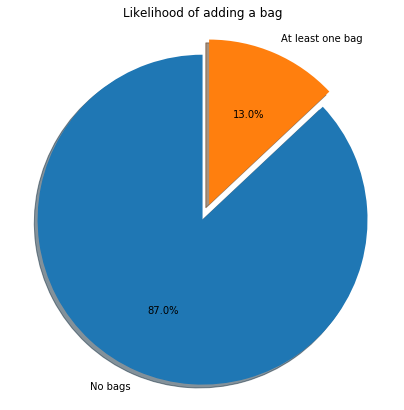

In [50]:
fig,ax=plt.subplots(figsize=(7,7))
s2=dict(df.Booked.value_counts())
vals=list(s2.values())
labels=['No bags', 'At least one bag']
explode=(0,0.1)
#fig1, ax1 = plt.subplots()
ax.pie(vals, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Likelihood of adding a bag')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [51]:
bagsbyMonth= bagsdf.groupby(['TripFirstTravelMonth', 'QuantityBooked']).size().reset_index(name='counts')

In [52]:
month={}

for i in range(1,13):
    sum=0
    for ind in bagsbyMonth.index:
        if (bagsbyMonth.TripFirstTravelMonth[ind]==i):
            sum = sum + bagsbyMonth.QuantityBooked[ind]*bagsbyMonth.counts[ind]
        month[i]=sum
    

In [53]:
winter=['Jan','Nov', 'Dec']
spring=['Feb', 'Mar', 'Apr']
summer=['May', 'Jun', 'Jul']
autumn=['Aug', 'Sep', 'Oct']

fig, ax = plt.subplots(figsize=(10,10))
#color=['red'] + ['green']*3 + ['blue']*3 + ['yellow']*3 +['red']*2
from matplotlib.patches import Patch

color=dict.fromkeys(winter, 'blue')
color.update(dict.fromkeys(spring, 'yellow'))
color.update(dict.fromkeys(summer, 'orange'))
color.update(dict.fromkeys(autumn, 'brown'))
colours={'winter': 'blue', 'spring':'yellow', 'summer':'orange', 'autumn':'brown'}

time=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
color={k:color[k] for k in time}

ax.bar(month.keys(), month.values(), color=color.values())


handlesleg=[
    Patch(color='blue', label='winter'),
    Patch(color='yellow', label='spring'),
    Patch(color='orange', label='summer'),
    Patch(color='brown', label='autumn')
]
plt.legend(handles=handlesleg)
#time=range(1,13,1)
ax.set_xticks(range(1,13,1))
ax.set_xticklabels(time)
ax.tick_params(labelsize=15)
ax.set_xlabel("Month", fontsize=25)
ax.set_ylabel("Count", fontsize=25)
ax.set_title("Count of Bags for each Month", fontsize=40)

fig.show()
#to do
#color-code bars by season
#subscripts #no of bags

C:\Users\oyino\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


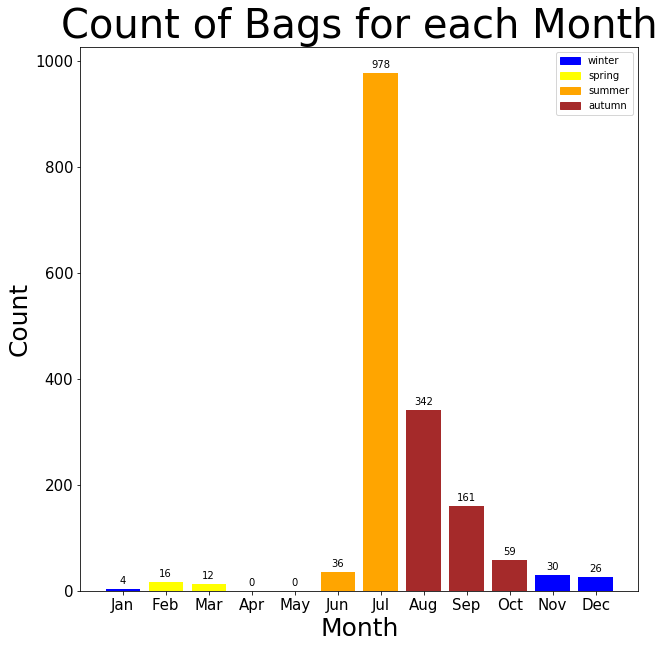

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
#color=['red'] + ['green']*3 + ['blue']*3 + ['yellow']*3 +['red']*2
from matplotlib.patches import Patch

color=dict.fromkeys(winter, 'blue')
color.update(dict.fromkeys(spring, 'yellow'))
color.update(dict.fromkeys(summer, 'orange'))
color.update(dict.fromkeys(autumn, 'brown'))
colours={'winter': 'blue', 'spring':'yellow', 'summer':'orange', 'autumn':'brown'}

time=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
color={k:color[k] for k in time}

im=ax.bar(month.keys(), month.values(), color=color.values())


handlesleg=[
    Patch(color='blue', label='winter'),
    Patch(color='yellow', label='spring'),
    Patch(color='orange', label='summer'),
    Patch(color='brown', label='autumn')
]
plt.legend(handles=handlesleg)
#time=range(1,13,1)
ax.set_xticks(range(1,13,1))
ax.set_xticklabels(time)
ax.tick_params(labelsize=15)
ax.set_xlabel("Month", fontsize=25)
ax.set_ylabel("Count", fontsize=25)
ax.set_title("Count of Bags for each Month", fontsize=40)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(im)
fig.show()
#to do
#color-code bars by season
#subscripts #no of bags

# Prediction

In [55]:
y=df.pop('Booked').values
df.pop('QuantityBooked')
X=df.values


In [56]:
X.shape
y.shape

(10000,)

In [57]:
from collections import Counter

In [58]:
print("Minority class : %0.2f" % (Counter(y)[1]/len(y)))

Minority class : 0.13


In [327]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [329]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [330]:
from sklearn.utils import shuffle

In [331]:
X_train, y_train = shuffle(X_train, y_train)

# Neural Network 

In [332]:
#pip install pygame

In [333]:
import torch

In [334]:
import torch.nn as nn

In [335]:
from torch.utils.data import TensorDataset, DataLoader

## SMOTE => Bias

In [336]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [337]:
sm = SMOTE(random_state=42, sampling_strategy=1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [338]:
y_train_res[y_train_res==1].shape

(6940,)

In [339]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [340]:
X_train.shape

(8000, 497)

In [341]:
type(X_train)

numpy.ndarray

In [342]:
X_train_new = torch.from_numpy(X_train_res).float()
y_train_new = torch.squeeze(torch.from_numpy(y_train_res).float())
X_test_new = torch.from_numpy(X_test).float()
y_test_new = torch.squeeze(torch.from_numpy(y_test).float())

In [343]:
#y_train_new[y_train_new==1].shape


In [344]:
print(X_train_new.shape, y_train_new.shape)
print(X_test_new.shape, y_test_new.shape)

torch.Size([13880, 497]) torch.Size([13880])
torch.Size([2000, 497]) torch.Size([2000])


In [345]:
n_input_dim=X_train_new.shape[1] #= the number of features
n_hidden =8
n_output = 1

In [346]:
class Net(nn.Module):
    def __init__(self, n_input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [347]:
net=Net(n_input_dim)
#print(net)

In [348]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

In [349]:
from sklearn import metrics

In [350]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train_new = X_train_new.to(device)
y_train_new = y_train_new.to(device)
X_test_new = X_test_new.to(device)
y_test_new = y_test_new.to(device)
net = net.to(device)
criterion = criterion.to(device)

In [351]:
y_train_new[y_train_new==0].shape

torch.Size([6940])

In [352]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

In [353]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)

In [354]:
EPOCHS = 1000
for epoch in range(EPOCHS):
    y_pred =torch.squeeze(net(X_train_new))
   
    #y_pred=net(X_train_new)
    #print(y_pred.shape)
    train_loss = criterion(y_pred, y_train_new)
    
    if epoch % 100 == 0:
        #train_acc = calculate_accuracy(y_train_new, y_pred)
        train_acc = metrics.roc_auc_score(y_train_new.detach().numpy(), y_pred.detach().numpy())
        y_test_pred = net(X_test_new)
        
        y_test_pred = torch.squeeze(y_test_pred)
        #print(y_test_pred)
        test_loss = criterion(y_test_pred, y_test_new)
        print(type(train_loss))
        #test_acc = calculate_accuracy(y_test_new, y_test_pred)
        test_acc = metrics.roc_auc_score(y_test_new.detach().numpy(), y_test_pred.detach().numpy())
        print(type(test_acc))
        print(f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
        
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

<class 'torch.Tensor'>
<class 'numpy.float64'>
epoch 0
Train set - loss: 0.693, accuracy: 0.495
Test  set - loss: 0.712, accuracy: 0.5

<class 'torch.Tensor'>
<class 'numpy.float64'>
epoch 100
Train set - loss: 0.412, accuracy: 0.904
Test  set - loss: 0.565, accuracy: 0.633

<class 'torch.Tensor'>
<class 'numpy.float64'>
epoch 200
Train set - loss: 0.112, accuracy: 0.995
Test  set - loss: 0.663, accuracy: 0.607

<class 'torch.Tensor'>
<class 'numpy.float64'>
epoch 300
Train set - loss: 0.041, accuracy: 1.0
Test  set - loss: 0.919, accuracy: 0.599

<class 'torch.Tensor'>
<class 'numpy.float64'>
epoch 400
Train set - loss: 0.021, accuracy: 1.0
Test  set - loss: 1.142, accuracy: 0.597

<class 'torch.Tensor'>
<class 'numpy.float64'>
epoch 500
Train set - loss: 0.013, accuracy: 1.0
Test  set - loss: 1.327, accuracy: 0.594

<class 'torch.Tensor'>
<class 'numpy.float64'>
epoch 600
Train set - loss: 0.01, accuracy: 1.0
Test  set - loss: 1.515, accuracy: 0.593

<class 'torch.Tensor'>
<class 'nu